In [42]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import ML_Crosstalk

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [43]:
qubits = 2
date = "2024-09-05_18-52"
name = "Qubits_3_Lines_10000_TS_2_Shots_10000_MeanDecay_0.4_MeanW_0_MeanJ_0_Std_1_Correlations_0_16.csv"
location = "C:\Projects\Crosstalk\Machine_Learning\Data/final/3qubits-shots-Done/" + name

# train_df = ML_Crosstalk.load_training_data(location)
# test_df = ML_Crosstalk.load_test_data(location)
data = pd.read_csv(location)
train_df, test_df = ML_Crosstalk.split_data(data, 0.1)


train_df.head()
print(len(train_df))

4500


In [44]:
from tensorflow.python.keras.regularizers import L2, L1

learning_rate = 0.0001
epochs = 500
batch_size = 100

# Get all column names as a list
input_keys, output_keys = ML_Crosstalk.get_keys(train_df, qubits)

inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in input_keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))

# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]


nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = ML_Crosstalk.build_model(concatenated_inputs, len(nodes_per_layer), output_keys, nodes_per_layer)

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_0_0 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_0_1 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_0_2 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_0_3 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_0_4 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_0_5 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Y_0_0 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Y_0_1 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Y_0_2 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Y_0_3 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Y_0_4 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Y_0_5 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decay_2             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_2 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ J_1 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 15)        │          0 │ X_0_0[0][0],      │
│ (Concatenate)       │                   │            │ X_0_1[0][0],      │
│                     │                   │            │ X_0_2[0][0],      │
│                     │                   │            │ X_0_3[0][0],      │
│                     │                   │            │ X_0_4[0][0],      │
│                     │                   │            │ X_0_5[0][0],      │
│                     │                   │            │ Y_0_0[0][0],      │
│                     │                   │            │ Y_0_1[0][0],      │
│                     │                   │            │ Y_0_2[0][0],      │
│                     │                   │            │ Y_0_3[0][0],      │
│                     │                   │            │ Y_0_4[0][0],      │
│                     │                   │            │ Y_0_5[0][0],      │
│                     │                   │            │ decay_2[0][0],    │
│                     │                   │            │ W_2[0][0],        │
│                     │                   │            │ J_1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │        512 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 28,149 (109.96 KB)

 Trainable params: 28,149 (109.96 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0559 - val_loss: 0.0640
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0554 - val_loss: 0.0642
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0565 - val_loss: 0.0639
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - val_loss: 0.0647
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - val_loss: 0.0636
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 - val_loss: 0.0649
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0559 - val_loss: 0.0637
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0551 - val_loss: 0.0641
Epoch 9/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546 - val_loss: 0.0634
Epoch 10/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - val_loss: 0.0633
Epoch 11/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - val_loss: 0.0637
Epoch 12/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

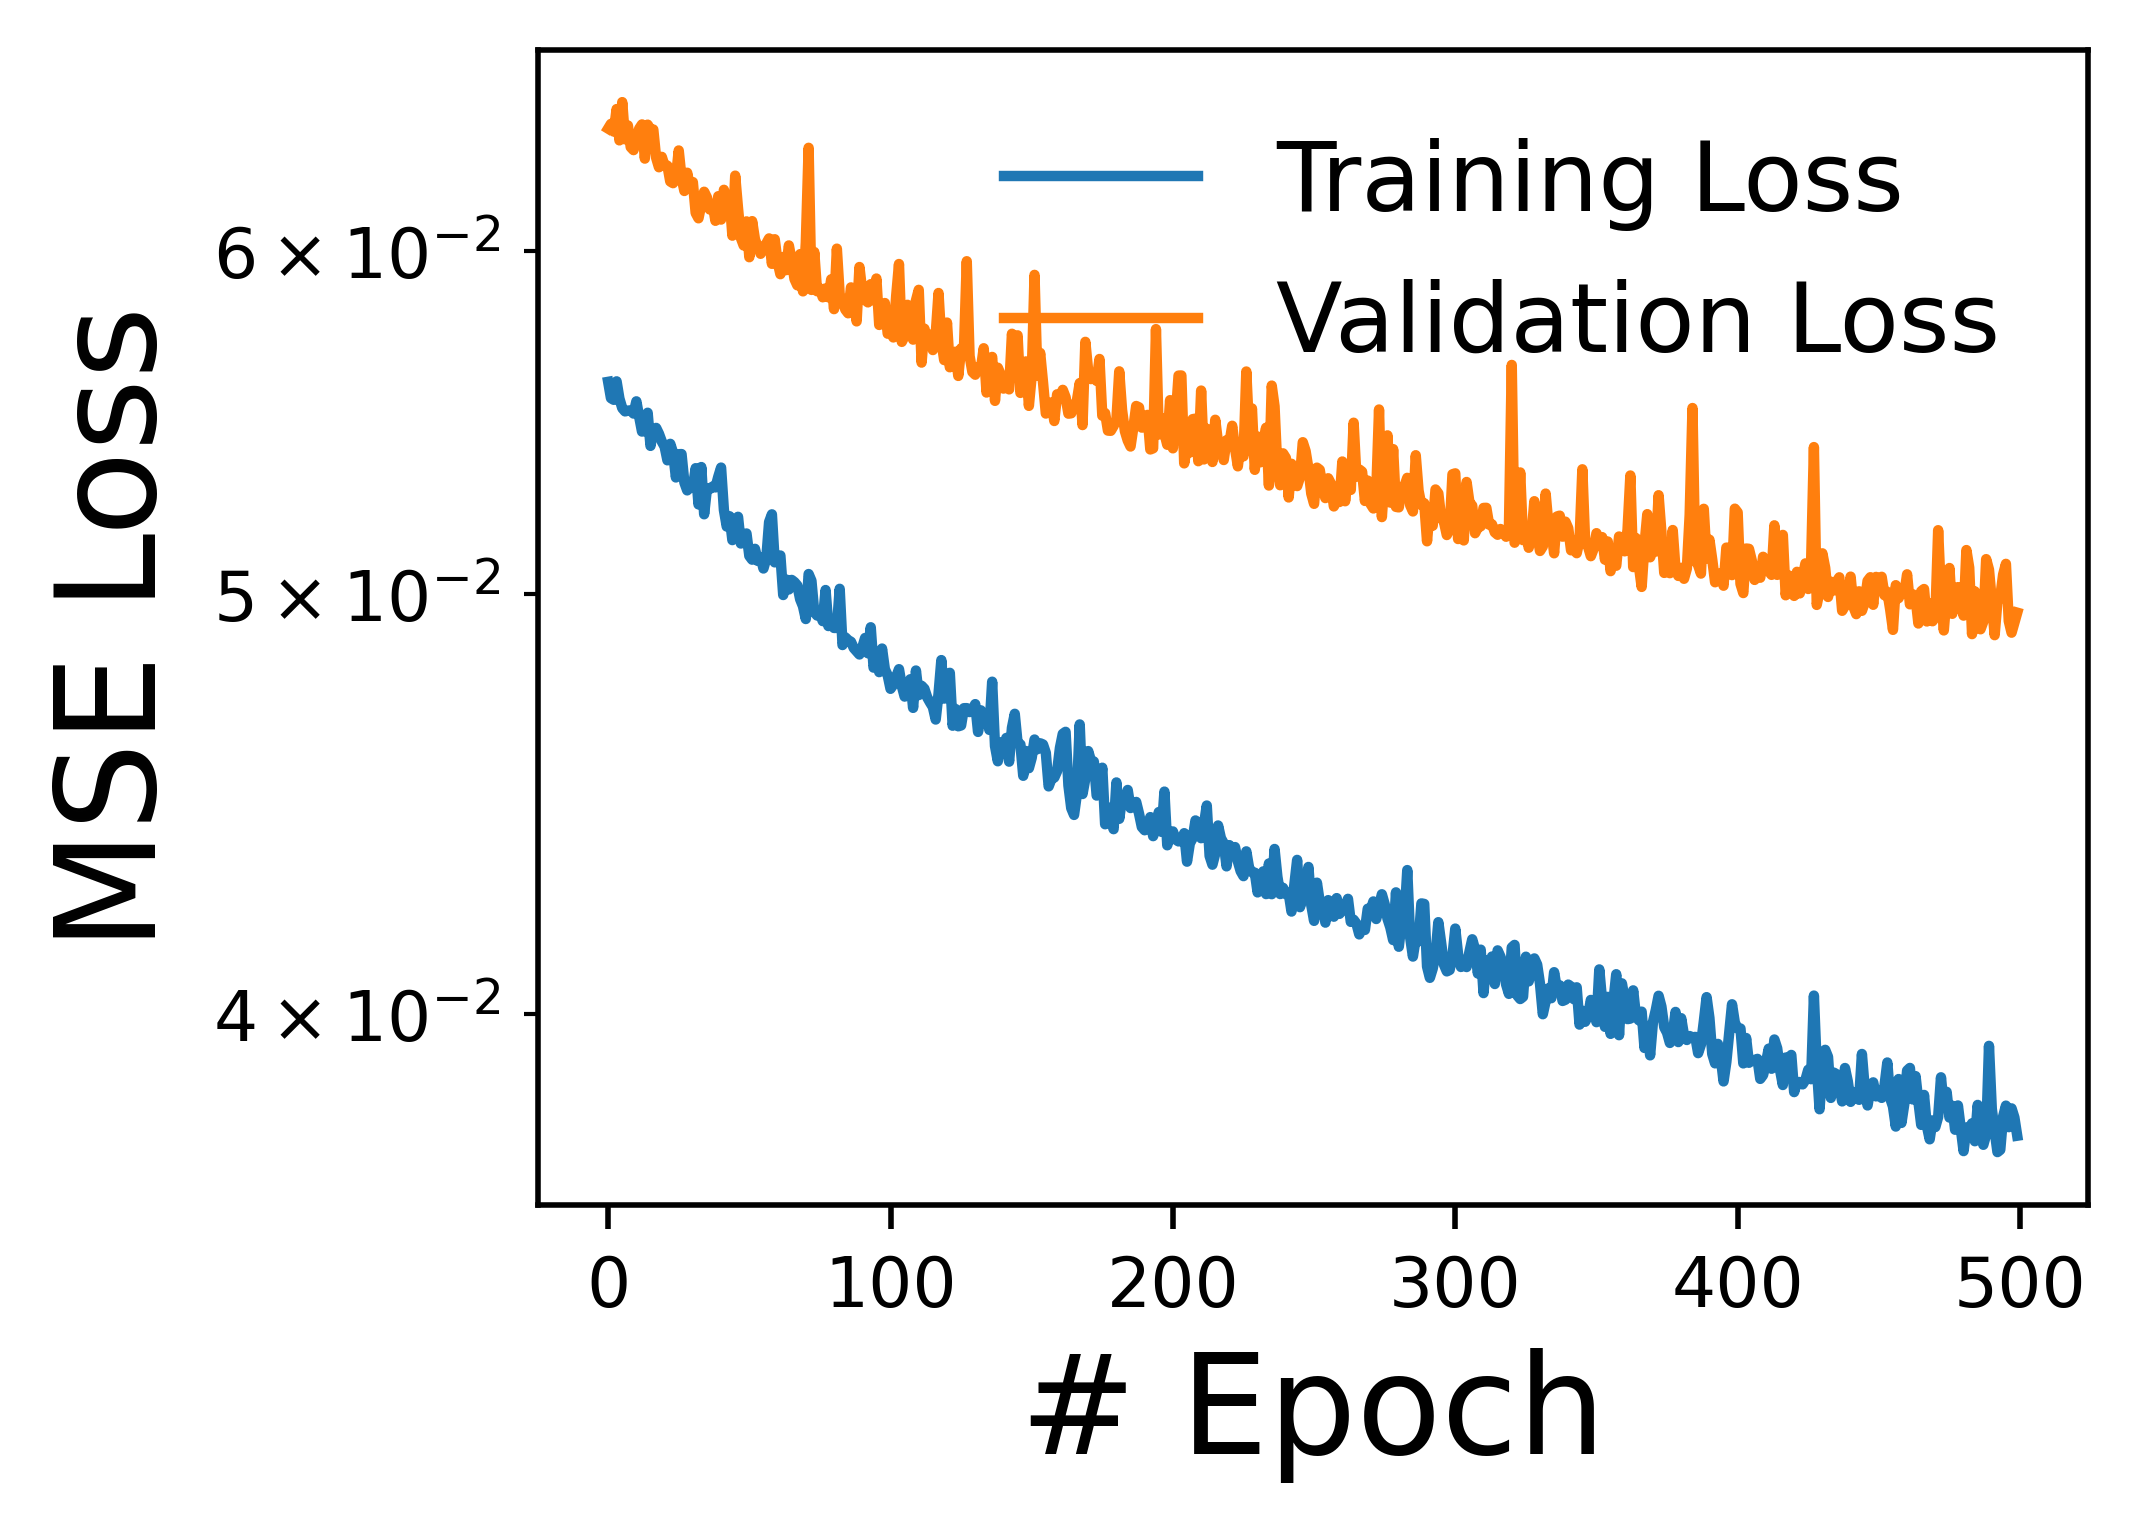

In [52]:
epochs_range = range(epochs)
plt.rcParams['figure.figsize'] = [4, 3]  # width, height
plt.rcParams["figure.dpi"] = 500
xl='# Epoch'
yl='MSE Loss'
title=''
base_size=16
xtickx_size=10

# Plotting
# plt.figure(figsize=(16, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.xlabel(xl, fontsize=base_size + 4)
plt.ylabel(yl, fontsize=base_size + 4)
plt.title(title, fontsize=base_size + 3)
plt.legend(fontsize=base_size - 2, frameon=False)
plt.xticks(fontsize=xtickx_size + 4)
plt.tick_params(axis='both', which='major', labelsize=xtickx_size)
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [53]:
import numpy as np
import estimator

new_data = test_df
first_line = new_data.iloc[15]
# correct_output = first_lie[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
correct_output = first_line[ML_Crosstalk.get_output_keys(qubits)].array

#input_data = {key: [first_line[key]] for key in inputs}
input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0][0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted values:  0.3910446
Correct values:  <PandasArray>
[ 0.4068306717980046,  0.4252122755786798, -0.1731997716454164,
  0.5178548331705471,  0.9739037494375754]
Length: 5, dtype: float64
the mean squared error is:  0.004528604944678783
The percent error is:  10.334257143567193


In [54]:
error = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    # correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
    correct_output = line[
       ML_Crosstalk.get_output_keys(qubits)].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)
    error.append(estimator.percent_error(predictions[0], correct_output))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [55]:
print("The mean percent error is: ", np.mean(error) * 100)

The mean percent error is:  10.330874867530495


In [125]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][0][j], correct_output[j]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [126]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 21.14048892259431 precent
The mean error for decay_1 is: 29.513848007879584 precent
The mean error for W_0 is: 408.22536167818157 precent
The mean error for W_1 is: 32.036623575115335 precent
The mean error for J_0 is: 8072.218115692011 precent
total error is:  1712.6268875751566


In [13]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 